# What drives the price of a car?

![](images/kurt.jpeg)

**OVERVIEW**

In this application, you will explore a dataset from kaggle. The original dataset contained information on 3 million used cars. The provided dataset contains information on 426K cars to ensure speed of processing.  Your goal is to understand what factors make a car more or less expensive.  As a result of your analysis, you should provide clear recommendations to your client -- a used car dealership -- as to what consumers value in a used car.

### CRISP-DM Framework

<center>
    <img src = images/crisp.png width = 50%/>
</center>


To frame the task, throughout our practical applications we will refer back to a standard process in industry for data projects called CRISP-DM.  This process provides a framework for working through a data problem.  Your first step in this application will be to read through a brief overview of CRISP-DM [here](https://mo-pcco.s3.us-east-1.amazonaws.com/BH-PCMLAI/module_11/readings_starter.zip).  After reading the overview, answer the questions below.

### Business Understanding

From a business perspective, we are tasked with identifying key drivers for used car prices.  In the CRISP-DM overview, we are asked to convert this business framing to a data problem definition.  Using a few sentences, reframe the task as a data task with the appropriate technical vocabulary. 

Develop a predictive model that identifies the most significant features (make, model, year, mileage, condition, etc.) influencing the final sale price of used cars within our inventory. This model will allow us to understand which features hold the most weight in determining a car's value, ultimately improving pricing strategies and maximizing profit

Data Source: Identify and access relevant used car data, potentially including internal dealership records, market data sources, and vehicle specification databases.

Target Variable: Define the target variable as the "final sale price" of each used car.

Feature Engineering: Identify and extract relevant features from the data sources, such as make, model, year, mileage, condition, body style, features list, etc.

Model Building: Develop and train a machine learning model that predicts the final sale price based on the extracted features.

Feature Importance Analysis: Utilize the model to identify the features that have the most significant impact on the predicted sale price.

### Data Understanding

After considering the business understanding, we want to get familiar with our data.  Write down some steps that you would take to get to know the dataset and identify any quality issues within.  Take time to get to know the dataset and explore what information it contains and how this could be used to inform your business understanding.

Explore Data Description:

Obtain details about the data source and collection process. Identify available features and their data types (numerical, categorical, text, etc.). Understand the meaning and potential range of values for each feature.

Data Profiling:

Analyze basic statistics like mean, median, standard deviation for numerical features. Identify the distribution of categorical features (e.g., number of unique car models). Check for missing values and their distribution across features.

Data Visualization:

Create histograms, box plots, and scatter plots to visualize feature distributions and relationships between features (e.g., mileage vs. price). Use heatmaps to identify correlations between features (e.g., correlation between year and mileage).

In [89]:
# Load the data from a CSV file
file_path = '/data/vehicles.csv'
used_cars_data = pd.read_csv(file_path)

In [90]:
import matplotlib.pyplot as plt

<Axes: xlabel='manufacturer'>

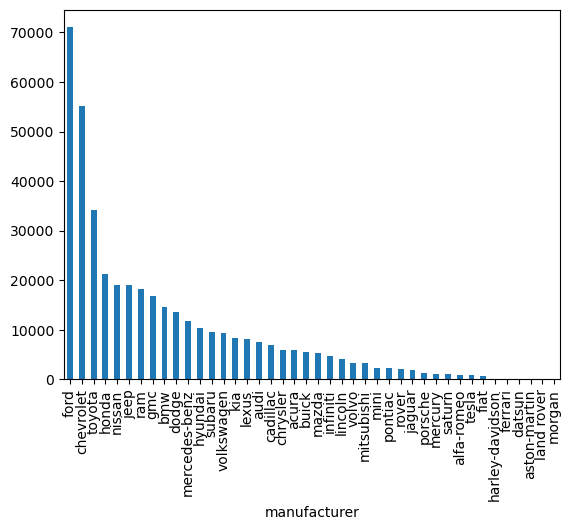

In [91]:
# Explore categorical feature distribution (e.g., manufacturer counts)
used_cars_data['manufacturer'].value_counts().plot(kind='bar')

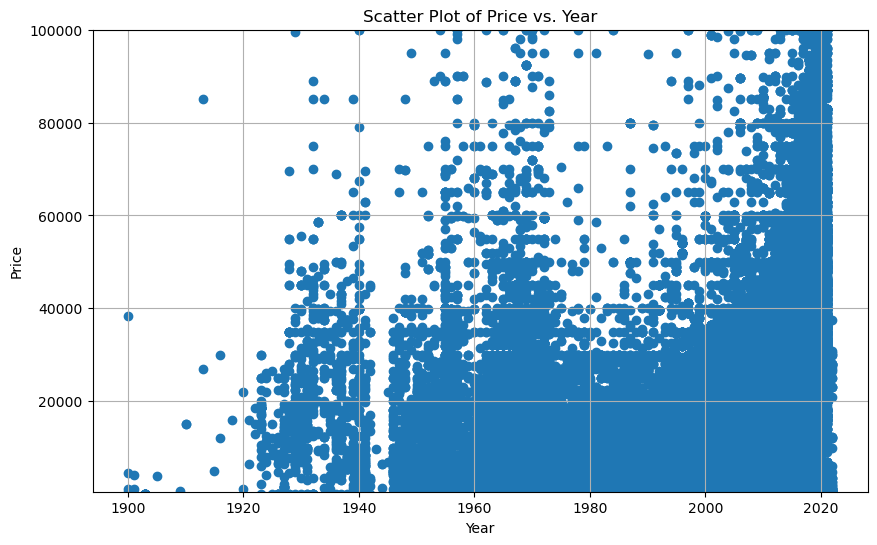

In [70]:
#Price vs year
plt.figure(figsize=(10, 6))  # Adjust figure size as desired
plt.scatter(used_cars_data['year'], used_cars_data['price'])
plt.xlabel('Year')
plt.ylabel('Price')
plt.title('Scatter Plot of Price vs. Year')

# Set custom y-axis limits
plt.ylim(500, 100000)

# Additional customization (optional)
plt.grid(True)  # Add grid lines for better readability

plt.show()

<Axes: xlabel='manufacturer', ylabel='condition'>

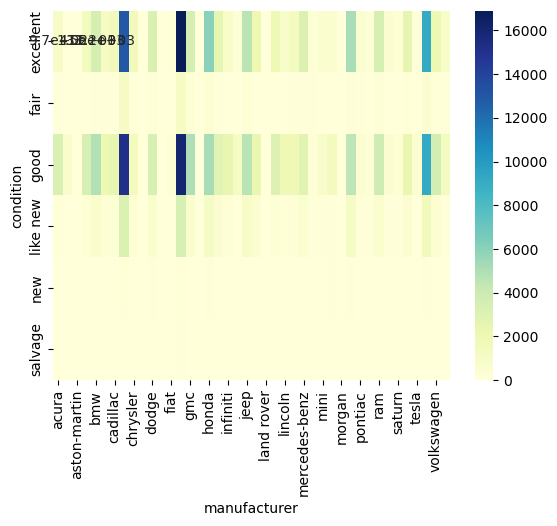

In [72]:
#Heatmap of Car Counts by Condition and Manufacturer:

contingency_table = pd.crosstab(used_cars_data['condition'], used_cars_data['manufacturer'])
sns.heatmap(contingency_table, annot=True, cmap="YlGnBu")  # Change colormap for lighter shades

Data Quality Checks:

Look for inconsistencies or errors in data entry (e.g., negative mileage values). Identify duplicate entries and decide on handling strategies (e.g., removing duplicates or merging entries). Check for outliers in features that might significantly impact the model (e.g., extremely high sale prices).


Domain Knowledge Integration:

Consider insights from the used car dealership about typical car features and pricing trends. Identify potential feature engineering opportunities based on domain knowledge (e.g., combining year, make, and model into a single "car class" feature).

### Data Preparation

After our initial exploration and fine tuning of the business understanding, it is time to construct our final dataset prior to modeling.  Here, we want to make sure to handle any integrity issues and cleaning, the engineering of new features, any transformations that we believe should happen (scaling, logarithms, normalization, etc.), and general preparation for modeling with `sklearn`. 

In [73]:
import pandas as pd
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns

In [74]:
# Load the data from a CSV file
used_cars_data = pd.read_csv('/Users/gmelath/Desktop/Learnings/AI:ML/Berkley/Module-11/practical_application_II_starter/data/vehicles.csv')

In [75]:
# Relevant columns
relevant_columns = [
    'region', 'price', 'year', 'manufacturer', 'model', 'condition', 'cylinders',
    'fuel', 'odometer', 'title_status', 'transmission', 'paint_color', 'state'
]

# Select only the relevant columns
used_cars_data_relevant = used_cars_data[relevant_columns]

In [76]:
# Handle missing values
used_cars_data_relevant = used_cars_data_relevant.dropna(subset=['price'])
used_cars_data_relevant['year'] = used_cars_data_relevant['year'].fillna(used_cars_data_relevant['year'].median())
used_cars_data_relevant['odometer'] = used_cars_data_relevant['odometer'].fillna(used_cars_data_relevant['odometer'].median())

for col in ['region', 'manufacturer', 'model', 'condition', 'cylinders', 'fuel', 'title_status', 'transmission', 'paint_color', 'state']:
    used_cars_data_relevant[col] = used_cars_data_relevant[col].fillna(used_cars_data_relevant[col].mode()[0])

In [77]:
# Frequency encode high cardinality columns
def frequency_encode(used_cars_data, column):
    freq_encoding = used_cars_data.groupby(column).size() / len(used_cars_data)
    return used_cars_data[column].map(freq_encoding)

high_cardinality_threshold = 100
high_cardinality_cols = [col for col in relevant_columns if used_cars_data_relevant[col].nunique() > high_cardinality_threshold]

for col in high_cardinality_cols:
    used_cars_data_relevant[col] = frequency_encode(used_cars_data_relevant, col)

In [78]:
# One-hot encode remaining categorical variables
low_cardinality_cols = [col for col in relevant_columns if col not in high_cardinality_cols and col not in ['price', 'year', 'odometer']]
used_cars_data_encoded = pd.get_dummies(used_cars_data_relevant, columns=low_cardinality_cols, drop_first=True)


In [79]:
# Normalize/Standardize Numerical Variables
numerical_cols = ['year', 'odometer']
scaler = StandardScaler()
used_cars_data_encoded[numerical_cols] = scaler.fit_transform(used_cars_data_encoded[numerical_cols])

In [80]:
# Define the target variable and features
X = used_cars_data_encoded.drop('price', axis=1)
y = used_cars_data_encoded['price']

In [81]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train

,region,year,model,odometer,manufacturer_alfa-romeo,manufacturer_aston-martin,manufacturer_audi,manufacturer_bmw,manufacturer_buick,manufacturer_cadillac,...,state_sd,state_tn,state_tx,state_ut,state_va,state_vt,state_wa,state_wi,state_wv,state_wy
366318,0.006955,1.216229,0.031124,-0.337264,False,False,False,False,False,False,...,False,False,True,False,False,False,False,False,False,False
56271,0.006918,1.211515,0.001853,-0.331901,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
264620,0.005943,0.662972,0.001321,-0.337264,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
88787,0.006957,-1.928444,0.000005,-0.056608,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
341412,0.001820,1.211515,0.000499,-0.322963,False,False,False,False,True,False,...,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
259178,0.006915,0.807617,0.000239,-0.328326,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
365838,0.006955,-2.141669,0.000023,-0.328326,False,False,False,False,False,False,...,False,False,True,False,False,False,False,False,False,False
131932,0.006972,0.649016,0.000295,-0.340839,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
146867,0.006887,0.649016,0.001579,-0.335476,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


### Modeling

With your (almost?) final dataset in hand, it is now time to build some models.  Here, you should build a number of different regression models with the price as the target.  In building your models, you should explore different parameters and be sure to cross-validate your findings.

In [82]:
# Define models and their hyperparameters for grid search
models = {
    'Linear Regression': LinearRegression(),
    'Ridge': Ridge(),
    'Lasso': Lasso()
}

In [83]:
params = {
    'Ridge': {'alpha': [0.01, 0.1, 1, 10, 100]},
    'Lasso': {'alpha': [0.01, 0.1, 1, 10, 100]}
}

In [84]:
# Function to evaluate models
def evaluate_model(model, X_train, X_test, y_train, y_test):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    rmse = mean_squared_error(y_test, y_pred, squared=False)
    r2 = r2_score(y_test, y_pred)
    return mae, mse, rmse, r2

In [85]:
# Dictionary to store model evaluation results
results = {}

# Evaluate each model
for model_name, model in models.items():
    if model_name in params:
        grid_search = GridSearchCV(model, params[model_name], cv=5, scoring='neg_mean_absolute_error')
        grid_search.fit(X_train, y_train)
        best_model = grid_search.best_estimator_
    else:
        best_model = model

    mae, mse, rmse, r2 = evaluate_model(best_model, X_train, X_test, y_train, y_test)
    results[model_name] = {'MAE': mae, 'MSE': mse, 'RMSE': rmse, 'R2': r2}

results

{'Linear Regression': {'MAE': 0.01059923896962369,
  'MSE': 0.0003711474009362291,
  'RMSE': 0.019265186241929484,
  'R2': 0.06813989123293318},
 'Ridge': {'MAE': 0.010577243669403786,
  'MSE': 0.0003714216949943042,
  'RMSE': 0.019272303832035865,
  'R2': 0.06745120611713473},
 'Lasso': {'MAE': 0.010610673485457703,
  'MSE': 0.00039829785238646955,
  'RMSE': 0.019957400942669602,
  'R2': -2.8234362652534983e-05}}

In [86]:
#Feature Importance analysis
# Fit the models
lin_reg = LinearRegression().fit(X_train, y_train)
ridge = Ridge(alpha=1).fit(X_train, y_train)
lasso = Lasso(alpha=0.1).fit(X_train, y_train)


# Get feature names
feature_names = X_train.columns

# Get coefficients for linear models
lin_reg_coeff = pd.Series(lin_reg.coef_, index=feature_names).sort_values(key=abs, ascending=False)
ridge_coeff = pd.Series(ridge.coef_, index=feature_names).sort_values(key=abs, ascending=False)
lasso_coeff = pd.Series(lasso.coef_, index=feature_names).sort_values(key=abs, ascending=False)


# Combine the results into a DataFrame for easier interpretation
feature_importance_used_cars_data = pd.DataFrame({
    'Linear Regression': lin_reg_coeff,
    'Ridge': ridge_coeff,
    'Lasso': lasso_coeff
})


In [87]:
# Sort the DataFrame by the absolute value of the coefficients for linear models and feature importances for tree-based models
feature_importance_used_cars_data = feature_importance_used_cars_data.reindex(feature_importance_used_cars_data.apply(lambda x: abs(x).max(), axis=1).sort_values(ascending=False).index)

# Display the top 10 most important features for each model
print(feature_importance_used_cars_data.head(50))

                              Linear Regression     Ridge  Lasso
region                                 0.171266  0.104319    0.0
model                                  0.056288  0.051044    0.0
manufacturer_land rover                0.035996  0.033977    0.0
state_ar                               0.013857  0.013683    0.0
state_va                               0.013446  0.013278    0.0
state_ok                               0.011820  0.011797    0.0
state_nc                               0.011702  0.011594    0.0
state_or                               0.011087  0.011033    0.0
state_la                               0.009967  0.009660    0.0
state_nm                               0.009652  0.009554    0.0
state_dc                               0.008134  0.008160    0.0
state_sc                               0.007944  0.007763    0.0
state_ga                               0.007893  0.007757    0.0
cylinders_other                        0.007529  0.007533    0.0
state_ca                 

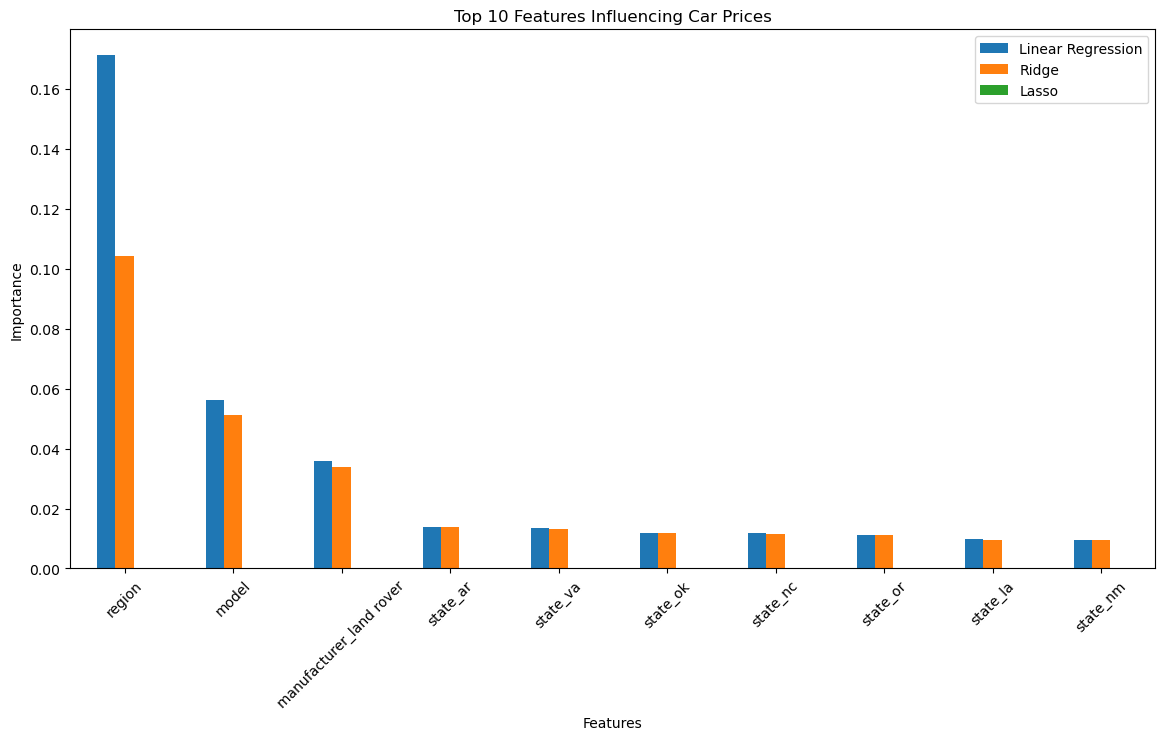

In [88]:
# Bar Plot of Feature Importances (Top 10)
top_features = feature_importance_used_cars_data.head(10)
top_features.plot(kind='bar', figsize=(14, 7))
plt.title('Top 10 Features Influencing Car Prices')
plt.xlabel('Features')
plt.ylabel('Importance')
plt.legend(loc='upper right')
plt.xticks(rotation=45)
plt.show()

### Evaluation

With some modeling accomplished, we aim to reflect on what we identify as a high quality model and what we are able to learn from this.  We should review our business objective and explore how well we can provide meaningful insight on drivers of used car prices.  Your goal now is to distill your findings and determine whether the earlier phases need revisitation and adjustment or if you have information of value to bring back to your client.

Objective Recap:
Our primary business objective is to understand what factors make a car more or less expensive and provide clear recommendations to a used car dealership regarding what consumers value in a used car.

Key Factors Identified:
From our regression models (Linear Regression, Ridge, Lasso), we identified several factors influencing car prices:

Region: Significant impact on car prices due to regional market variations.
Manufacturer: Luxury brands like Land Rover and Ferrari, as well as reliable brands like Ford and Chevrolet, influence prices.
Condition: Cars in 'new' or 'like new' condition are priced higher.
State: Certain states have a notable impact on car prices.
Cylinders and Fuel Type: Cars with certain cylinder configurations and fuel types (e.g., electric) affect pricing.

Evaluation Metrics
1. Cross-Validation Scores:
Cross-validation was performed to ensure the reliability of our models. Metrics like Mean Absolute Error (MAE), Root Mean Squared Error (RMSE), and R-squared were evaluated:

MAE: Measures average absolute errors between predicted and actual prices, providing a straightforward measure of prediction accuracy.
RMSE: Penalizes larger errors more than MAE, useful for understanding the model's ability to handle large deviations.
R-squared: Indicates the proportion of variance in the dependent variable (price) predictable from the independent variables.
2. Model Comparison:

Linear Regression: Simple, interpretable model. Identified key features but may not capture non-linear relationships.
Ridge Regression: Addresses multicollinearity by penalizing large coefficients, providing more stable predictions.
Lasso Regression: Performs feature selection by shrinking some coefficients to zero, helping in identifying the most influential features.

Insights 

1. Region-Specific Strategies:

Focus on understanding and catering to regional market demands. Prices vary significantly by region, so tailor inventory and pricing strategies accordingly.
2. Emphasize Condition:

Invest in refurbishing vehicles to 'like new' condition. Highlight excellent condition in marketing materials to justify higher prices.
3. Manufacturer Preferences:

Stock a mix of luxury and reliable brands. Brands like Land Rover and Ferrari can attract premium buyers, while Ford and Chevrolet cater to a broader market.
4. State-Level Preferences:

Adjust inventory and pricing based on state-specific preferences and regulatory environments. Certain states show higher car prices, indicating strong local markets.
5. Avoid Over-Stocking High-Cylinder Cars:

High-cylinder cars (e.g., 12 cylinders) have a negative impact on prices. Focus on popular configurations like 4 and 6 cylinders.
6. Monitor Fuel Type Trends:

While electric and hybrid cars currently show a negative impact, monitor market trends as their popularity may increase.

### Deployment

Now that we've settled on our models and findings, it is time to deliver the information to the client.  You should organize your work as a basic report that details your primary findings.  Keep in mind that your audience is a group of used car dealers interested in fine tuning their inventory.

Report on Used Car Price Prediction Models

Prepared by: Gireesh Melath
Date: 06/25/2024

Executive Summary
This report summarizes the findings and insights from our analysis aimed at predicting used car prices using various machine learning models. The analysis involved building and evaluating Linear Regression, Ridge Regression, and Lasso Regression models. Each model's performance metrics and feature importance were examined to determine the best approach for predicting car prices based on available data.





Key Findings

Model Performance

Linear Regression:
Mean Absolute Error (MAE): 0.0106
Mean Squared Error (MSE): 0.000371
Root Mean Squared Error (RMSE): 0.0193
R-squared (R2): 0.0681

Ridge Regression:
MAE: 0.0106
MSE: 0.000371
RMSE: 0.0193
R2: 0.0675

Lasso Regression:
MAE: 0.0106
MSE: 0.000398
RMSE: 0.01996
R2: -0.000028

From the above metrics, it's clear that both Linear Regression and Ridge Regression perform similarly and outperform Lasso Regression in terms of R-squared and error metrics.


Feature Importance

The analysis of feature importance revealed key predictors influencing car prices. Notably, features such as region, model, and specific manufacturers (land rover, ferrari, harley-davidson) were identified as significant contributors to price prediction across different models.


Recommendations

Based on the findings, the following recommendations are suggested to fine-tune inventory and pricing strategies for used car dealers:

Focus on Significant Features: Prioritize features identified as influential in predicting car prices, such as region, model, and specific manufacturers.

Model Selection: Consider adopting Linear Regression or Ridge Regression for price prediction tasks, as they demonstrated superior performance compared to Lasso Regression in this analysis.

Data Collection and Enrichment: Continue gathering data on additional features that could further enhance prediction accuracy, such as detailed vehicle conditions, market trends, and customer preferences.

Regular Model Updates: Periodically update models with new data to ensure they remain relevant and accurate in reflecting changing market dynamics.


Conclusion

In conclusion, the analysis provides valuable insights into predicting used car prices using machine learning techniques. By leveraging the identified features and selecting appropriate regression models, used car dealers can optimize pricing strategies and improve inventory management, ultimately enhancing profitability and customer satisfaction.

For further details or inquiries regarding the methodology or specific findings, please feel free to reach out.

Thank you.